In [35]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from model import Autoencoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt

In [36]:
torch.cuda.empty_cache()
train_X = pd.read_csv("data/train_X.csv").values
val_X   = pd.read_csv("data/val_X.csv").values
X_test  = pd.read_csv("data/X_test.csv").values
y_test  = pd.read_csv("data/y_test.csv").values.squeeze()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataset = TensorDataset(torch.tensor(train_X, dtype=torch.float32))
val_tensor = torch.tensor(val_X, dtype=torch.float32).to(device)
train_loader = DataLoader(train_dataset, batch_size=8192, shuffle=True, pin_memory=True)

In [37]:
# RUN 1 (16 - > 8 -> 4 (Bottleneck) -> 8 -> 16)
    # Train X shape: (9813926, 18) | min: 0.0 | max: 1.0
    # MAD K Multiplier -> 2.75
    # Data Seed: 42
# RUN 2 (16 -> 8 -> 4 (Bottleneck) -> 8 -> 16)
    # Train X shape: (7851141, 18) | min: 0.0 | max: 1.0
    # MAD K Multiplier -> 3
    # Data Seed: 42
# RUN 3 (16 -> 8 -> 4 (Bottleneck) -> 8 -> 16)
    # Train X shape: (5888356, 18) | min: 0.0 | max: 1.0
    # MAD K Multiplier -> 3
    # Data Seed: 42
# RUN 4 (16 -> 8 -> 4 (Bottleneck) -> 8 -> 16)


model = Autoencoder(18).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [38]:
patience = 5
min_delta = 1e-4
best_val_loss = float('inf')
wait = 0
epochs = 50

for epoch in range(epochs):
    start_time = time.time()
    model.train()
    train_loss = 0.0

    for batch in train_loader:
        inputs = batch[0].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)

    model.eval()
    with torch.no_grad():
        val_output = model(val_tensor)
        val_loss = criterion(val_output, val_tensor).item()

    epoch_time = time.time() - start_time

    print(f"Epoch {epoch+1}/{epochs} | Time: {epoch_time:.2f}s | "
          f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

    if best_val_loss - val_loss > min_delta:
        best_val_loss = val_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f"Stopped early: {epoch+1}")
            break

Epoch 1/50 | Time: 17.15s | Train Loss: 0.629862 | Val Loss: 0.507768
Epoch 2/50 | Time: 17.06s | Train Loss: 0.359435 | Val Loss: 0.301354
Epoch 3/50 | Time: 16.70s | Train Loss: 0.291469 | Val Loss: 0.281801
Epoch 4/50 | Time: 16.76s | Train Loss: 0.267321 | Val Loss: 0.252373
Epoch 5/50 | Time: 16.61s | Train Loss: 0.235981 | Val Loss: 0.220510
Epoch 6/50 | Time: 16.84s | Train Loss: 0.209183 | Val Loss: 0.200923
Epoch 7/50 | Time: 16.64s | Train Loss: 0.197273 | Val Loss: 0.194628
Epoch 8/50 | Time: 16.72s | Train Loss: 0.192302 | Val Loss: 0.190170
Epoch 9/50 | Time: 16.85s | Train Loss: 0.188118 | Val Loss: 0.186070
Epoch 10/50 | Time: 16.66s | Train Loss: 0.184611 | Val Loss: 0.183252
Epoch 11/50 | Time: 16.92s | Train Loss: 0.182047 | Val Loss: 0.180714
Epoch 12/50 | Time: 16.71s | Train Loss: 0.178933 | Val Loss: 0.176742
Epoch 13/50 | Time: 16.78s | Train Loss: 0.174235 | Val Loss: 0.172366
Epoch 14/50 | Time: 16.79s | Train Loss: 0.171627 | Val Loss: 0.171097
Epoch 15/50 | T

MAD-based threshold: 0.000372


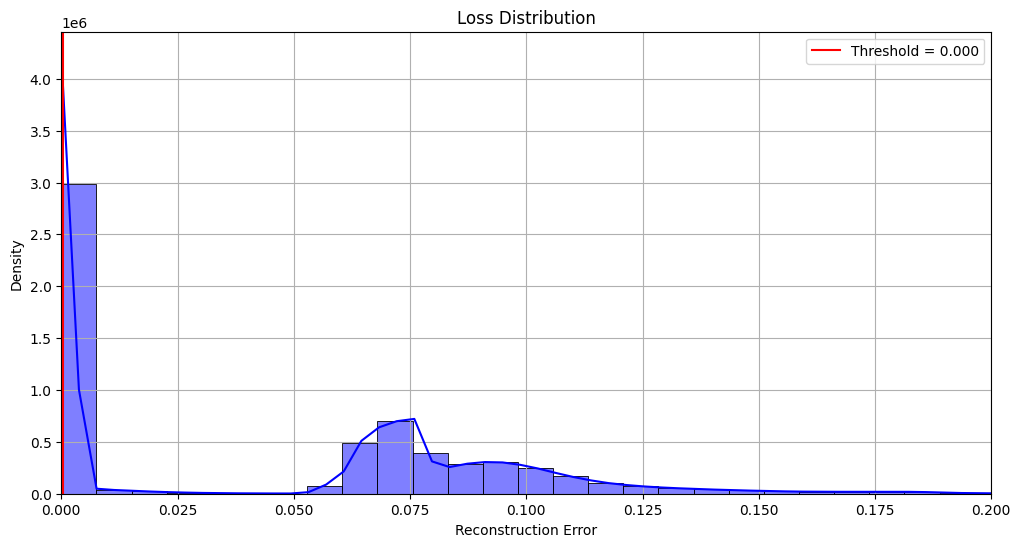

In [ ]:
test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
with torch.no_grad():
    reconstructions = model(test_tensor).cpu().numpy()

reconstruction_errors = np.mean((X_test - reconstructions) ** 2, axis=1)

benign_errors = reconstruction_errors[y_test == 0]
median = np.median(benign_errors)
mad = np.median(np.abs(benign_errors - median))
threshold = median + 3 * mad

print(f"MAD-based threshold: {threshold:.6f}")

plt.figure(figsize=(12, 6))
plt.title("Loss Distribution")

sns.histplot(reconstruction_errors, bins=100, kde=True, color='blue')
plt.axvline(threshold, color='red', linestyle='-', label=f"Threshold = {threshold:.3f}")
plt.xlabel("Reconstruction Error")
plt.ylabel("Density")
plt.xlim(0, 0.2)
plt.grid(True)
plt.legend()
plt.savefig("results/16_8_4_60DS_42/LossDistribution.png", dpi=300)
plt.show()
plt.close()


In [40]:
y_pred = (reconstruction_errors > threshold).astype(int)

print(f"Threshold: {threshold:.6f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

with open("results/16_8_4_60DS_42/ClassificationReport.txt", "w") as f:
    f.write(f"Threshold: {threshold:.6f}\n\n")
    f.write(classification_report(y_test, y_pred, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

with open("results/16_8_4_60DS_42/ConfusionMatrix.txt", "w") as f:
    f.write("Confusion Matrix:\n")
    np.savetxt(f, confusion_matrix(y_test, y_pred), fmt='%d')

Threshold: 0.000372

Classification Report:

              precision    recall  f1-score   support

           0     1.0000    0.8845    0.9387   3066853
           1     0.8964    1.0000    0.9454   3066853

    accuracy                         0.9422   6133706
   macro avg     0.9482    0.9422    0.9420   6133706
weighted avg     0.9482    0.9422    0.9420   6133706

Confusion Matrix:
[[2712586  354267]
 [      0 3066853]]


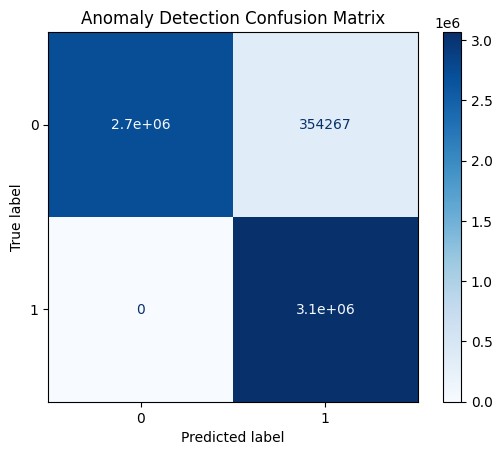

In [ ]:
cm = confusion_matrix(y_test, y_pred)
class_names = ['Class 0', 'Class 1']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y):,}'))
plt.savefig("Anomaly_Detection_Confusion_Matrix.png")
plt.title("Anomaly Detection Confusion Matrix")
plt.savefig("results/16_8_4_60DS_42/ConfusionMatrixGraph.png", dpi=300)
plt.show()
plt.close()

In [42]:
torch.save(model.state_dict(), "results/16_8_4_60DS_42/Model.pth")